# **M1 Exam Submission part 2**

## **Table of Contents**

#### I. Import Libraries and Data
#### II. Data Preparation
#### III. Model Development
#### IV. Model Evaluation

### Funding Duration Prediction:
### Target: funding_duration_days (Time to Secure Loan)

### Problem Statement:

The objective is to predict how long it will take for a loan request to be fully funded, based on factors such as the borrower's country, sector, activity type, loan amount, and number of lenders. By understanding these relationships, the model can provide insights into which factors lead to faster or slower funding times.
Type of Model:
The model will use regression, as the target variable (funding_duration_days) represents a continuous numerical value. The goal is to predict the number of days required to secure full funding for a loan based on the given features.
### Objective:
This model aims to assist lending platforms and financial institutions in forecasting how long a loan will take to be fully funded after a request is made. This can help in optimizing loan approval strategies, better managing borrower expectations, and allocating resources efficiently to improve funding success rates.

In [1]:
# install all requried libraries
!pip install -r https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/requirements.txt

In [2]:
#import libraries
import pandas as pd             # for data manipulation
import numpy as np              # for mathematical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for data visualization
from scipy.stats import zscore  # for standardizing data & removing outliers
import geopandas as gpd # for   # !!! check usecase of geopandas...
import altair as alt            # for interactive visualization
from vega_datasets import data  # for data visualization

#additional libraries for importing data from github
import requests                 # used for importing data
import io                       # used for converting response content to a file-like object for pandas

# library used for gender mapping - section 4
import re

In [9]:
# definition of url-paths for datasets
url1 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_0.csv?token=GHSAT0AAAAAACW5CC7BUKRXCRU7APTH5Q4EZX5FNYA'
url2 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_1.csv?token=GHSAT0AAAAAACW5CC7B5N3TSECZ4BHAIWIOZX5FN6A'
url3 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_2.csv?token=GHSAT0AAAAAACW5CC7AP4TAV3AH63VJT4RAZX5FN6Q'

# loading the urls into requests to download data
response1 = requests.get(url1)
response2 = requests.get(url2)
response3 = requests.get(url3)

# convert the response content to a file-like object for pandas using io.StringIO
# the advantage of StringIO is that it allows us to import the data without having to save it as a file for pandas
data_part1 = pd.read_csv(io.StringIO(response1.text))
data_part2 = pd.read_csv(io.StringIO(response2.text))
data_part3 = pd.read_csv(io.StringIO(response3.text))

# We can see, that the imported loan dataset consists of 3 parts. We will like to combine these to one dataset
data = pd.concat([data_part1, data_part2, data_part3])

### Data Preparation

In [10]:
# Dropping unnecessary columns
data = data.drop(['tags', 'use', 'currency', 'country_code', 'partner_id'], axis=1)

# we want to remove the missing rows from the dataset
# storing length of rows for comparing, >> before dropna.. <<
data_rows = len(data)

# dropping missing values
data.dropna(inplace=True)

# storing the now cleaned dataset
cleaned_rows = len(data)

# check..
drops = data_rows - cleaned_rows

# print the dropped rows and percentage of data removed
print(f"Number of dropped rows: {drops}")
print(f'In percentage {(drops / data_rows) * 100:.2f} % of the data was removed')
# check after cleaning
data.isna().sum()

Number of dropped rows: 97078
In percentage 14.46 % of the data was removed


id                    0
funded_amount         0
loan_amount           0
activity              0
sector                0
country               0
region                0
posted_time           0
disbursed_time        0
funded_time           0
term_in_months        0
lender_count          0
borrower_genders      0
repayment_interval    0
date                  0
dtype: int64

In [11]:
### Gender Mapping (creating groups of male, female, and mixed gender groups)
# count the number of male and female borrowers by searching for occurrences of 'male' and 'female' in the 'borrower_genders' column
data['male_borrowers'] = data['borrower_genders'].apply(lambda x: len(re.findall(r'\bmale', x)))
data['female_borrowers'] = data['borrower_genders'].apply(lambda x: len(re.findall(r'\bfemale', x)))

# calculate the total number of borrowers by adding male and female borrower counts
data['borrowers_count'] = data['male_borrowers'] + data['female_borrowers']

# handle cases where 'borrowers_count' is 0 by replacing it with 1 to avoid division by zero
data['male_borrower_ratio'] = data['male_borrowers'] / data['borrowers_count'].replace(0, 1)

# function to classify the gender group based on the ratio of male borrowers
# if the ratio is 1, it means all borrowers are male, so return 'male(s)'
# if the ratio is 0, all borrowers are female, so return 'female(s)'
# otherwise, return 'mixed gender group' for groups with both male and female borrowers
def classify_genders(ratio):
    if ratio == 1:
        return 'male(s)'
    elif ratio == 0:
        return 'female(s)'
    else:
        return 'mixed gender group'

# apply the gender classification function to each row based on the 'male_borrower_ratio'
data['gender_class'] = data['male_borrower_ratio'].apply(classify_genders)

# print of the first 10 rows of new added columns to see the borrower genders, counts, ratios, and classifications
data[['borrower_genders', 'male_borrowers', 'female_borrowers', 'borrowers_count', 'male_borrower_ratio', 'gender_class']].head(10)

,borrower_genders,male_borrowers,female_borrowers,borrowers_count,male_borrower_ratio,gender_class
0,female,0,1,1,0.0,female(s)
1,"female, female",0,2,2,0.0,female(s)
2,female,0,1,1,0.0,female(s)
3,female,0,1,1,0.0,female(s)
4,female,0,1,1,0.0,female(s)
6,female,0,1,1,0.0,female(s)
7,female,0,1,1,0.0,female(s)
8,female,0,1,1,0.0,female(s)
9,female,0,1,1,0.0,female(s)
10,female,0,1,1,0.0,female(s)


In [12]:
### Removing outliers based on loan_amount
# calculate z-scores for loan_amount (our outlier detection)
z_scores = zscore(data['loan_amount'])

# get boolean array indicating the presence of outliers
# using 2 & -2 z_scores to get 95% of data within 2 standard deviations
data['outlier_loan_amount'] = (z_scores > 2) | (z_scores < -2)


#removing outliers
data_clean = data[~data['outlier_loan_amount']]

# check amount of outliers (if any?)
data['outlier_loan_amount'].sum()

23129

### Calculating funding duration (time between posted_time and funded_time)

In [14]:
loans = data_clean
# We would like to also include the time/duration between posted_time and funded_time - in other words: how long it takes to get a loan funded
# convert to pd.datetime
loans['posted_time'] = pd.to_datetime(loans['posted_time'])
loans['funded_time'] = pd.to_datetime(loans['funded_time'])

# calculate time between posted_time and funded_time
loans['funding_duration'] = loans['funded_time'] - loans['posted_time']

# the result in days instead
loans['funding_duration_days'] = (loans['funded_time'] - loans['posted_time']).dt.total_seconds() / (24 * 60 * 60)

# first rows to check
loans[['posted_time', 'funded_time', 'funding_duration', 'funding_duration_days']].head()

/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_42159/3370879942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['posted_time'] = pd.to_datetime(loans['posted_time'])
/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_42159/3370879942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['funded_time'] = pd.to_datetime(loans['funded_time'])
/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_42159/3370879942.py:8: SettingWithCopyWarning: 
A value is trying to be set o

,posted_time,funded_time,funding_duration,funding_duration_days
0,2014-01-01 06:12:39+00:00,2014-01-02 10:06:32+00:00,1 days 03:53:53,1.162419
1,2014-01-01 06:51:08+00:00,2014-01-02 09:17:23+00:00,1 days 02:26:15,1.101562
2,2014-01-01 09:58:07+00:00,2014-01-01 16:01:36+00:00,0 days 06:03:29,0.252419
3,2014-01-01 08:03:11+00:00,2014-01-01 13:00:00+00:00,0 days 04:56:49,0.206123
4,2014-01-01 11:53:19+00:00,2014-01-01 19:18:51+00:00,0 days 07:25:32,0.309398


## SML Preparation

In [24]:
# Libs needed for section 7 (some already imported)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix

#  Model selection & Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# pipeline for the different models
from sklearn.pipeline import Pipeline

# decision Tree
from sklearn.tree import DecisionTreeRegressor

# tabular data explanation with LIME
import lime.lime_tabular  

# install shap & import
!pip install lime shap pdpbox -qqq

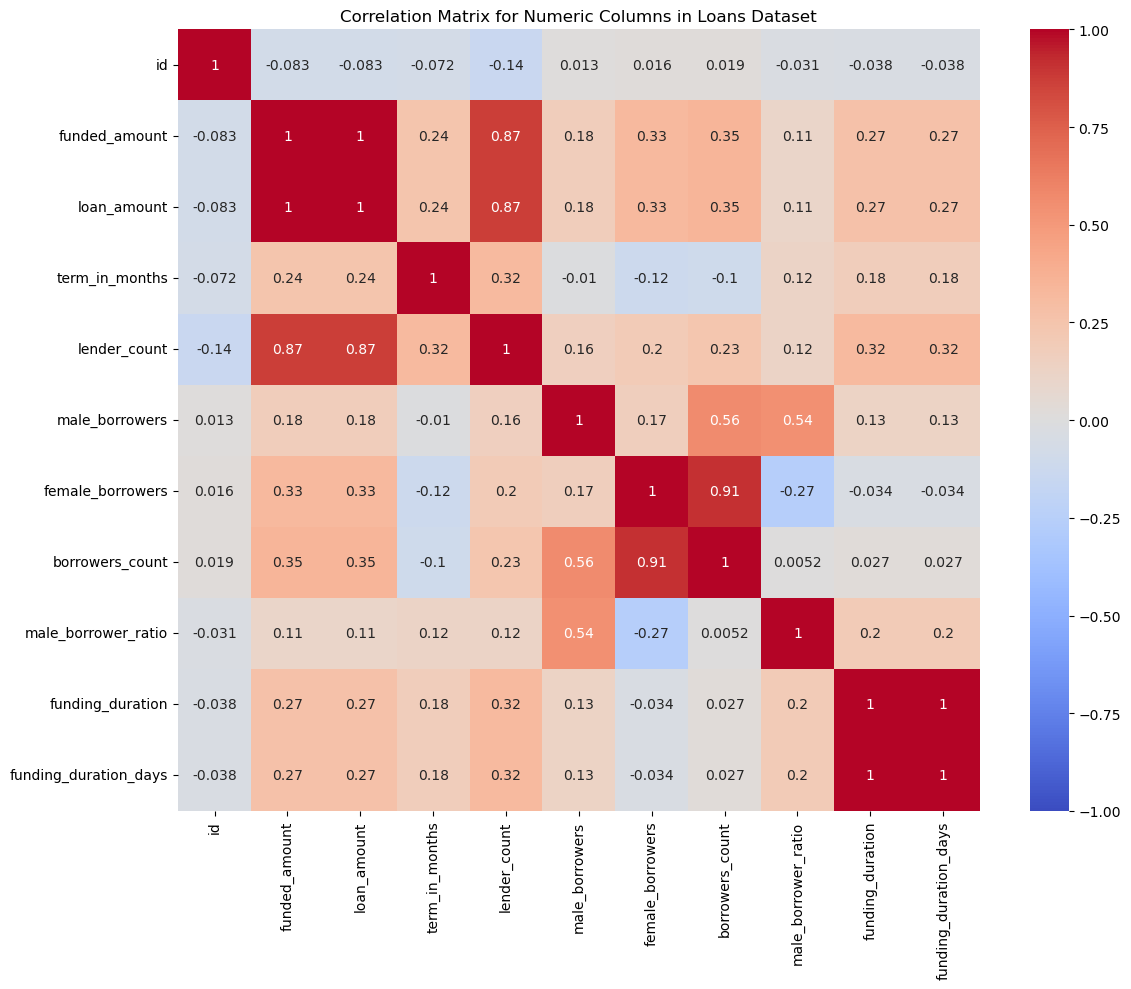

In [16]:
# it's a good idea to check the correlation matrix, to check if relevant columns may correlate to much with others
numeric_columns = loans.select_dtypes(include=[np.number]).columns

# Beregn korrelationsmatrix
corr_matrix = loans[numeric_columns].corr()

# Plot korrelationsmatrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Numeric Columns in Loans Dataset')
plt.tight_layout()
plt.show()

In [17]:
data_clean.head()

,id,funded_amount,loan_amount,activity,sector,country,region,posted_time,disbursed_time,funded_time,...,repayment_interval,date,male_borrowers,female_borrowers,borrowers_count,male_borrower_ratio,gender_class,outlier_loan_amount,funding_duration,funding_duration_days
0,653051,300.0,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,...,irregular,2014-01-01,0,1,1,0.0,female(s),False,1 days 03:53:53,1.162419
1,653053,575.0,575.0,Rickshaw,Transportation,Pakistan,Lahore,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,...,irregular,2014-01-01,0,2,2,0.0,female(s),False,1 days 02:26:15,1.101562
2,653068,150.0,150.0,Transportation,Transportation,India,Maynaguri,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,...,bullet,2014-01-01,0,1,1,0.0,female(s),False,0 days 06:03:29,0.252419
3,653063,200.0,200.0,Embroidery,Arts,Pakistan,Lahore,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,...,irregular,2014-01-01,0,1,1,0.0,female(s),False,0 days 04:56:49,0.206123
4,653084,400.0,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,...,monthly,2014-01-01,0,1,1,0.0,female(s),False,0 days 07:25:32,0.309398


In [18]:
#Filtering only the relevant columns for the model
relevant_columns = [
    'loan_amount',
    'activity',
    'sector',
    'country',
    'region',
    'posted_time',
    'funded_time',
    'borrowers_count',
    'gender_class',
    'funding_duration_days',
    'term_in_months',
]


In [19]:
loans_df = loans[relevant_columns]

### Sample of loan data

In [27]:
loans_df = loans_df.sample(n=30000, random_state=1)

In [31]:
loans_df.head()

,loan_amount,activity,sector,country,region,posted_time,funded_time,borrowers_count,gender_class,funding_duration_days,term_in_months
14360,500.0,Fruits & Vegetables,Food,El Salvador,San Vicente,2016-07-27 18:58:45+00:00,2016-08-21 19:12:13+00:00,1,female(s),25.009352,11.0
130770,475.0,Personal Housing Expenses,Housing,Vietnam,"Le Thuy, Quang Binh",2015-12-30 13:51:37+00:00,2015-12-31 23:49:34+00:00,1,female(s),1.415243,26.0
170233,600.0,Cattle,Agriculture,Uganda,Ishaka,2016-03-21 13:43:39+00:00,2016-04-03 23:57:56+00:00,1,male(s),13.426586,6.0
100775,200.0,Poultry,Agriculture,Kenya,Chuka,2015-11-02 05:28:21+00:00,2015-11-21 18:49:29+00:00,1,female(s),19.556343,14.0
30669,275.0,Motorcycle Transport,Transportation,Philippines,"Puerto Princesa, Palawan",2014-03-14 23:32:42+00:00,2014-03-17 11:30:34+00:00,1,female(s),2.498519,8.0


In [33]:
# define the target variable 'y' (loan_amount)
y = loans_df['loan_amount']

# define the feature set 'X' (all other columns except loan_amount)
X = loans_df[['activity', 'sector', 'country', 'borrowers_count', 'funding_duration_days', 'region', 'gender_class', 'term_in_months']]

# preprocessing for numeric features
numeric_features = ['borrowers_count', 'funding_duration_days', 'term_in_months']
numeric_transformer = StandardScaler()

# preprocessing for categorical features
categorical_features = ['activity', 'sector', 'country', 'region', 'gender_class']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

### Creating pipelines

In [34]:
# Pipeline for Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Pipeline for Decision Tree Regression
pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

# Pipeline for Random Forest Regression
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])
 
# Pipeline for XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

In [35]:
############################################################
# Train Linear Regression
pipeline_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Train & test score
train_score_lr = pipeline_lr.score(X_train, y_train)
test_score_lr = pipeline_lr.score(X_test, y_test)

print("Linear Regression Performance:")
print(f"  MSE: {mse_lr:.4f}")
print(f"  MAE: {mae_lr:.4f}")
print(f"  R²: {r2_lr:.4f}")
print(f"Train Score: {train_score_lr:.4f}")
print(f"Test Score: {test_score_lr:.4f}")

############################################################
# Train Decision Tree Regression
pipeline_tree.fit(X_train, y_train)

# Make predictions
y_pred_tree = pipeline_tree.predict(X_test)

# Evaluate
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Train & test score
train_score_tree = pipeline_tree.score(X_train, y_train)
test_score_tree = pipeline_tree.score(X_test, y_test)

print("\nDecision Tree Regression Performance:")
print(f"  MSE: {mse_tree:.4f}")
print(f"  MAE: {mae_tree:.4f}")
print(f"  R²: {r2_tree:.4f}")
print(f"Train Score: {train_score_tree:.4f}")
print(f"Test Score: {test_score_tree:.4f}")

############################################################
# Train Random Forest Regression
pipeline_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train & test score
train_score_rf = pipeline_rf.score(X_train, y_train)
test_score_rf = pipeline_rf.score(X_test, y_test)

print("\nRandom Forest Regression Performance:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
print(f"Train Score: {train_score_rf:.4f}")
print(f"Test Score: {test_score_rf:.4f}")

############################################################
# Train XGBoost Regression
pipeline_xgb.fit(X_train, y_train)

# Make predictions
y_pred_rf = pipeline_xgb.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train & test score
train_score_rf = pipeline_xgb.score(X_train, y_train)
test_score_rf = pipeline_xgb.score(X_test, y_test)

print("\nXGBoost Performance:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
print(f"Train Score: {train_score_rf:.4f}")
print(f"Test Score: {test_score_rf:.4f}")

############################################################

Linear Regression Performance:
  MSE: 103950.2941
  MAE: 219.5504
  R²: 0.5977
Train Score: 0.7322
Test Score: 0.5977

Decision Tree Regression Performance:
  MSE: 149070.4861
  MAE: 247.2639
  R²: 0.4231
Train Score: 1.0000
Test Score: 0.4231

Random Forest Regression Performance:
  MSE: 91131.2049
  MAE: 195.4241
  R²: 0.6473
Train Score: 0.9502
Test Score: 0.6473

XGBoost Performance:
  MSE: 86953.5110
  MAE: 202.0517
  R²: 0.6635
Train Score: 0.7472
Test Score: 0.6635
